In [1]:
import pandas as pd
#load_the_csv_file_ #data_without_prepro.csv

#ref:https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c

df = pd.read_csv("data_without_prepro.csv",encoding='latin-1')
df = df.fillna('')

In [2]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


**<font color=blue><h3>Preprocessing of Text</h3></font>**

- **Preprocessing:**
    - Removing html tags 
    - Removing Punctuations
    - Performing Stemming
    - Removing Stopwords
    - Expanding Contractions etc.

In [4]:
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [5]:
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

**<font color=blue><h3>Advanced Feature Extraction (NLP and Fuzzy Features)</h3></font>**

**Definition:**
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


**Features:**
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [6]:
#to_get_the_results_in_4_decemal_points
SAFE_DIV = 0.0001

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    #converting_the_sentence_into_tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    #get_the_non-stopwords_in_questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #get_the_non-stopwords_in_questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #get_the_common_non-stopwords_from_question_pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #get_the_common_stopwords_from_question_pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #get_the_common_token_from_question_pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    #last_word_of_both_question_is_same_or_not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    #first_word_of_both_question_is_same_or_not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #average_token_length_of_both_questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

In [7]:
#get_the_longest_common_sub_string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(data):
    #_preprocessing_each_question
    data["question1"] = data["question1"].fillna("").apply(preprocess)
    data["question2"] = data["question2"].fillna("").apply(preprocess)

    #_token_features_
    #merging_features_with_dataset
    token_features = data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    data["cwc_min"]       = list(map(lambda x: x[0], token_features))
    data["cwc_max"]       = list(map(lambda x: x[1], token_features))
    data["csc_min"]       = list(map(lambda x: x[2], token_features))
    data["csc_max"]       = list(map(lambda x: x[3], token_features))
    data["ctc_min"]       = list(map(lambda x: x[4], token_features))
    data["ctc_max"]       = list(map(lambda x: x[5], token_features))
    data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    data["first_word_eq"] = list(map(lambda x: x[7], token_features))
    data["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    data["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #_fuzzy_features_
    #computing_fuzzy_features_and_merging_with_dataset
    
    #reference_
    #http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    #https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    #https://github.com/seatgeek/fuzzywuzzy

    data["token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    
    #the_token_sort_approach_involves_tokenizing_the_string_in_question;_sorting_the_tokens_alphabetically_and_
    #then_joining_them_back_into_a_string;_we_then_compare_the_transformed_strings_with_a_simple_ratio()_
    
    data["token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    data["longest_substr_ratio"] = data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return data

In [8]:
data = pd.read_csv("D:/Applied_Ai/Case Studies/Quora/My Work/New/quora.csv") #load_the_csv_file_and_extract_the_features_
data = extract_features(data)

In [9]:
#save_data_in_csv_file
data.to_csv("nlp_features.csv", index=False)

In [10]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [11]:
data.columns.values #extracted_features_

array(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'], dtype=object)

**<font color=blue><h3>Analysis of Extracted Features</h3></font>**

**<font>Plotting Word Clouds</font>**

- Creating Word Cloud of Duplicates and Non-Duplicates question pairs.
- We can observe the most frequent occuring words.

In [12]:
data_duplicate = data[data['is_duplicate'] == 1]
data_non_duplicate = data[data['is_duplicate'] == 0]

#converting_2d_array_of_q1_and_q2_and_flatten_the_array_like_{{1,2},{3,4}}_to_{1,2,3,4}
p = np.dstack([data_duplicate["question1"], data_duplicate["question2"]]).flatten()
n = np.dstack([data_non_duplicate["question1"], data_non_duplicate["question2"]]).flatten()

print("NUMBER OF DATA POINTS IN CLASS 1 (DUPLICATE PAIRS) :",len(p))
print("NUMBER OF DATA POINTS IN CLASS 0 (NON_DUPLICATE PAIRS) :",len(n))

#saving_the_np_array_into_a_text_file_
file = open("train_p.txt", "w+")
file.write(str(p))
file.close()

file2 = open("train_n.txt", "w+")
file2.write(str(n))
file2.close()

NUMBER OF DATA POINTS IN CLASS 1 (DUPLICATE PAIRS) : 37298
NUMBER OF DATA POINTS IN CLASS 0 (NON_DUPLICATE PAIRS) : 62702


In [13]:
#reading_the_text_files_and_removing_the_stop_words:
from os import path
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")

print("TOTAL NUMBER OF WORDS IN DUPLICATE PAIR QUESTIONS :",len(textp_w))
print("TOTAL NUMBER OF WORDS IN NON DUPLICATE PAIR QUESTIONS :",len(textn_w))

TOTAL NUMBER OF WORDS IN DUPLICATE PAIR QUESTIONS : 389
TOTAL NUMBER OF WORDS IN NON DUPLICATE PAIR QUESTIONS : 363


**<font color=blue>Word Clouds Generated From Duplicate Pair Question's Text</font>**

WORD CLOUD FOR DUPLICATE PAIR QUESTIONS


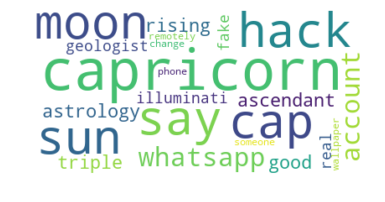

In [25]:
import matplotlib.pyplot as plt
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords) #textp_w_:_duplicate_pair_questions
wc.generate(textp_w)
print ("WORD CLOUD FOR DUPLICATE PAIR QUESTIONS")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**<font color=blue>Word Clouds Generated From Non-Duplicate Pair Question's Text</font>**

WORD CLOUD FOR NON DUPLICATE PAIR QUESTIONS


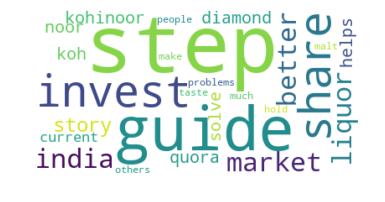

In [26]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords) #textn_w_:_non_duplicate_pair_questions
wc.generate(textn_w)
print ("WORD CLOUD FOR NON DUPLICATE PAIR QUESTIONS")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<font color=blue>**Analysis Feature:** fuzz_ratio</font>

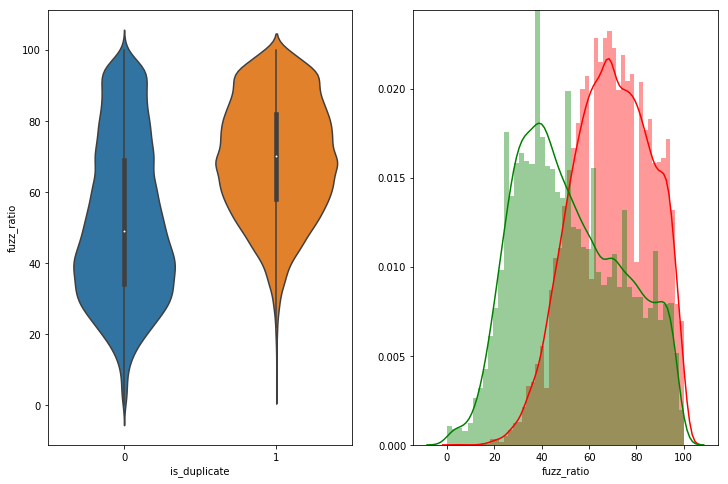

In [27]:
#distribution_of_the_fuzz_ratio
import seaborn as sns

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'green')

plt.show()

<font color=blue>**Analysis Feature:** token_sort_ratio</font>

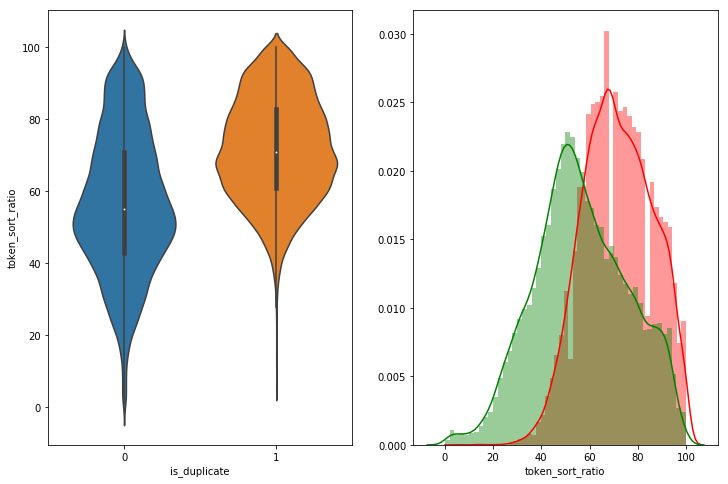

In [28]:
#distribution_of_the_token_sort_ratio

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'green')

plt.show()

There are some features which seems quite good and there is clear separation.

<font color=blue>**Analysis Features:** Pair Plot of Features - [ctc_min, cwc_min, csc_min, token_sort_ratio]</font>

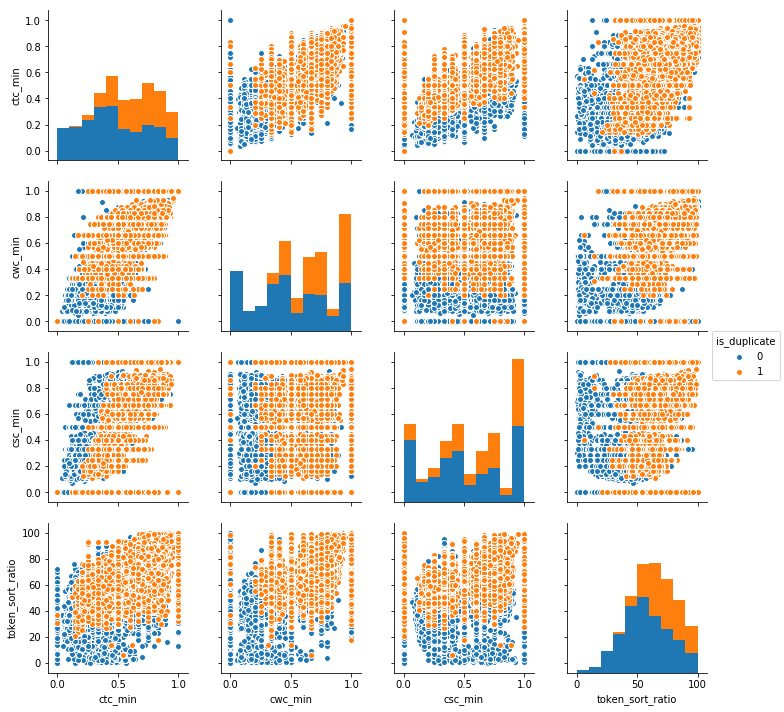

In [29]:
n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])

plt.show()

**<font color=blue><h3>Visualization</h3></font>**

In [22]:
#using_TSNE_for_dimentionality_reduction_for_15_features(_generated_after_cleaning_the_data_)_to_3_dimention

from sklearn.preprocessing import MinMaxScaler

data_subsampled = data[0:5000]
X = MinMaxScaler().fit_transform(data_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = data_subsampled['is_duplicate'].values

In [23]:
from sklearn.manifold import TSNE
#2d_visualization
tsne2d = TSNE(
    n_components=2,
    init='random', #pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.193s
[t-SNE] Iteration 50: error = 81.3439178, gradient norm = 0.0466835 (50 iterations in 1.078s)
[t-SNE] Iteration 100: error = 70.6513138, gradient norm = 0.0087385 (50 iterations in 0.944s)
[t-SNE] Iteration 150: error = 68.9511337, gradient norm = 0.0055224 (50 iterations in 0.920s)
[t-SNE] Iteration 200: error = 68.1303253, gradient norm = 0.0044136 (50 iterations in 0.911s)
[t-SNE] Iteration 250: error = 67.6239471, gradient norm = 0.0040027

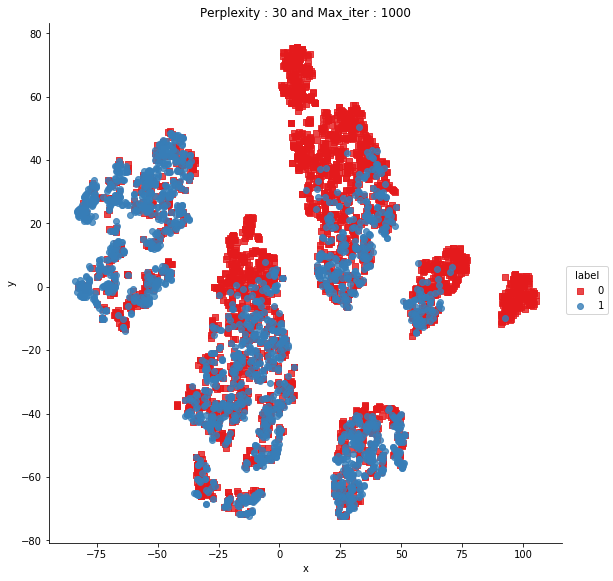

In [30]:
data = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

#draw_the_plot_in_appropriate_place_in_the_grid
sns.lmplot(data=data, x='x', y='y', hue='label', fit_reg=False, size=8, palette="Set1", markers=['s','o'])
plt.title("Perplexity : {} and Max_iter : {}".format(30, 1000))

plt.show()

In [32]:
#3d_visualization
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.026s...
[t-SNE] Computed neighbors for 5000 samples in 0.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.232s
[t-SNE] Iteration 50: error = 80.5757294, gradient norm = 0.0296225 (50 iterations in 2.550s)
[t-SNE] Iteration 100: error = 69.4228821, gradient norm = 0.0033213 (50 iterations in 1.553s)
[t-SNE] Iteration 150: error = 68.0054474, gradient norm = 0.0017131 (50 iterations in 1.553s)
[t-SNE] Iteration 200: error = 67.4455719, gradient norm = 0.0011530 (50 iterations in 1.542s)
[t-SNE] Iteration 250: error = 67.1334152, gradient norm = 0.0009050

In [33]:
import plotly.graph_objs as go
import plotly.tools as tls

import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3D EMBEDDING WITH ENGINEERED FEATURES')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<Figure size 432x288 with 0 Axes>